# Movie Reccommender

### Imports

In [95]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
from ast import literal_eval
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import evaluate
from surprise import Reader, Dataset, SVD

import warnings; warnings.simplefilter('ignore')
pd.set_option('display.max_columns', None)

ImportError: cannot import name 'evaluate' from 'surprise.model_selection' (/Users/dugaldmacintyre/anaconda3/lib/python3.10/site-packages/surprise/model_selection/__init__.py)

In [2]:
md = pd.read_csv('data/movies_metadata.csv')
md = md.drop([19730, 29503, 35587])
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [3]:
for i in list(md.columns):
    print(i)

adult
belongs_to_collection
budget
genres
homepage
id
imdb_id
original_language
original_title
overview
popularity
poster_path
production_companies
production_countries
release_date
revenue
runtime
spoken_languages
status
tagline
title
video
vote_average
vote_count


<Axes: >

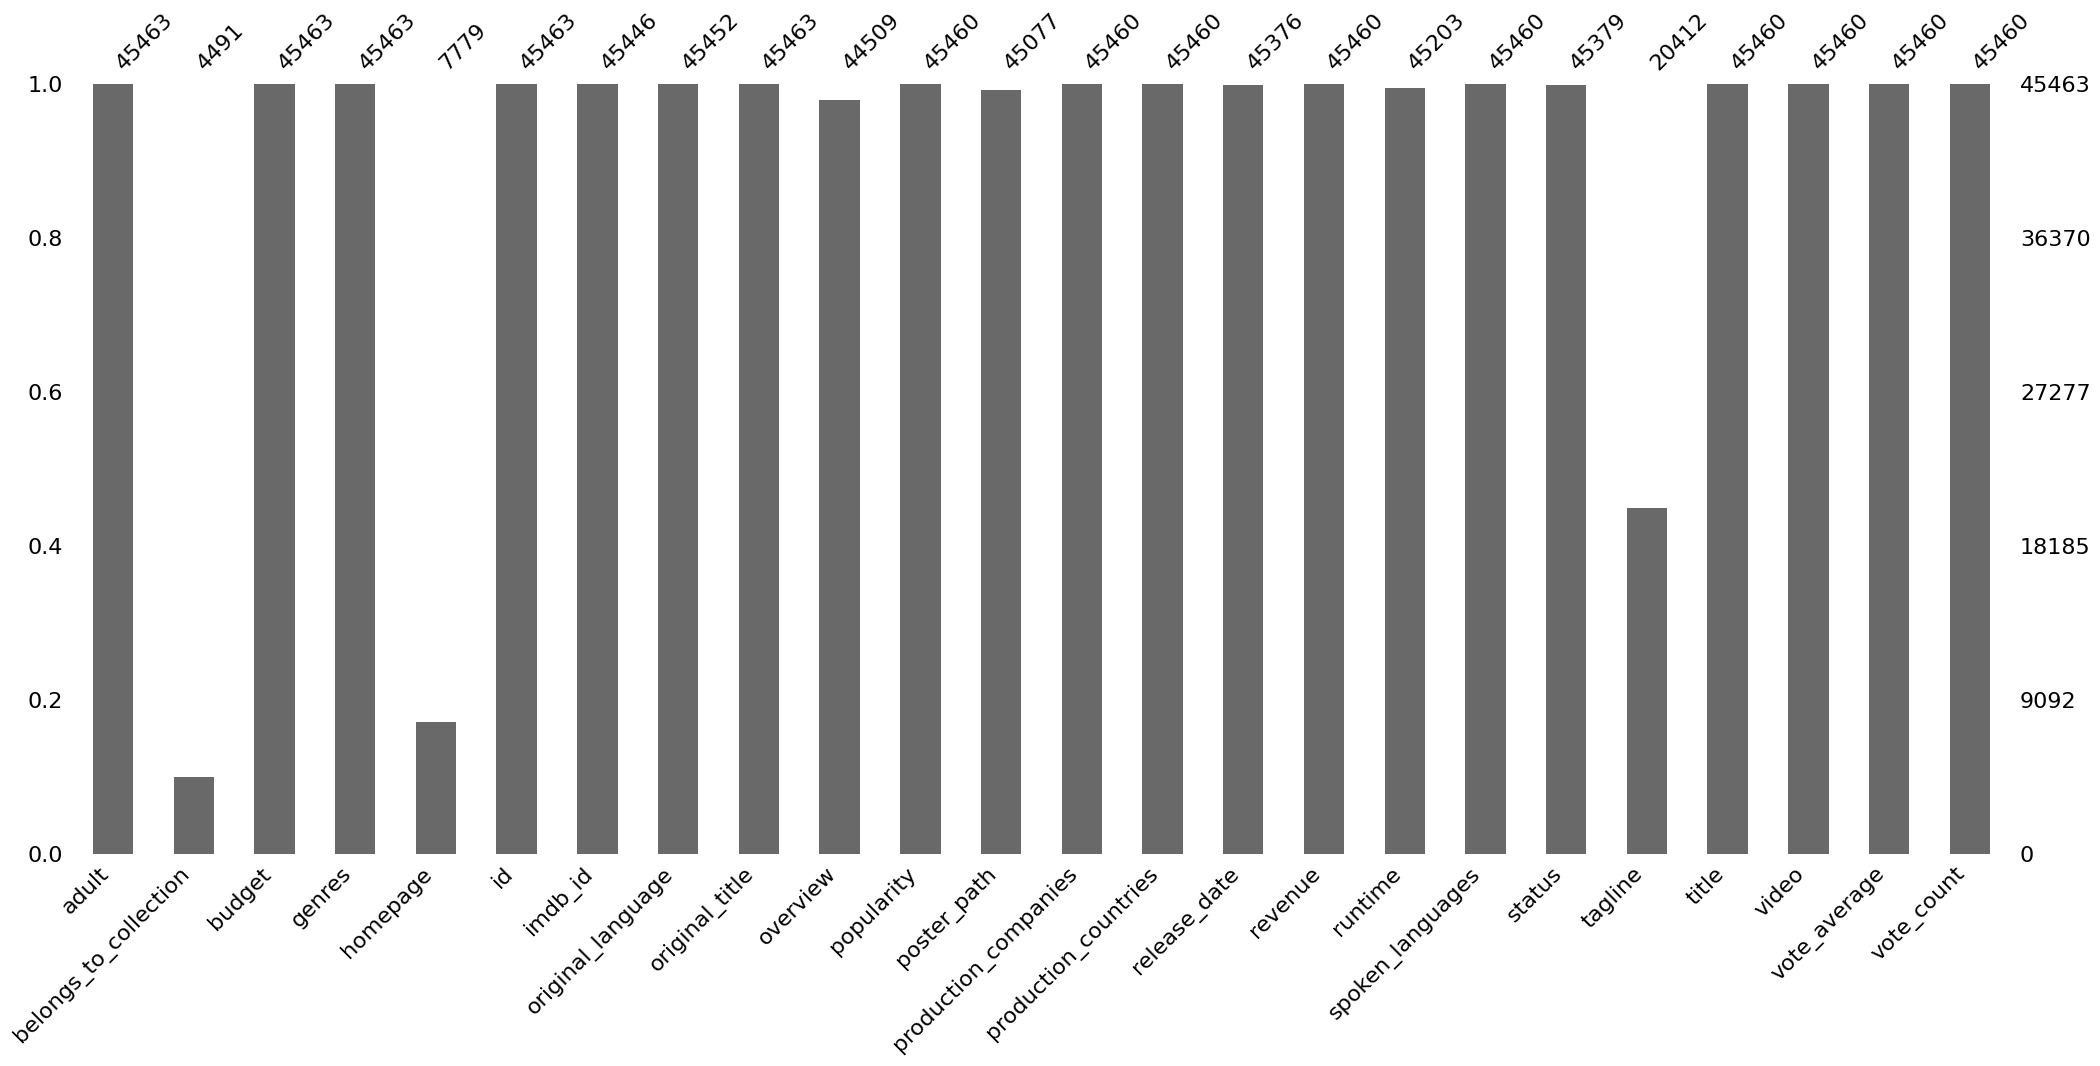

In [4]:
msno.bar(md)

### Cleaning up

Ideas:

- might be a good idea to try and drop really unpopular films, maybe define minimum threshholds for vote_count, budget, runtime?

- for our purposes, we may be able to get rid of certain columns such as status, homepage, tagline?, video

- replace belongs to collection values with numbers: not a collection - 0, trilogy - 3, etc.

### Getting Ratings for movies

Weighted Rating (WR) =  (v.R/(v+m))+(m.C/(v+m))
 
where,


- v is the number of votes for the movie
- m is the minimum votes required to be listed in the chart
- R is the average rating of the movie
- C is the mean vote across the whole report

<h1>Pipeline</h1>

In [5]:
def process_columns(df):
    df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
    df['genres'] = df['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
    
    
    df['tagline'] = df['tagline'].fillna('')
    df['description'] = df['overview'] + df['tagline']
    df['description'] = df['description'].fillna('')
    return df

In [6]:
def drop_columns(df):
    df.drop(['homepage', 'overview', 'poster_path', 'production_companies', 'production_countries', 'status', 'tagline', 'video'], axis=1, inplace=True)
    return df

In [7]:
def drop_na(df):
   df.dropna(axis=0, subset=['adult', 'budget', 'genres', 'id', 'imdb_id',
      'original_language', 'original_title', 'popularity',
      'release_date', 'revenue', 'runtime', 'spoken_languages', 'title',
      'vote_average', 'vote_count', 'year'], inplace = True)

   df.reset_index(drop=True, inplace=True)
   return df

In [8]:
def one_hot_genres(df):
    df.reset_index(drop=True)

    mlb = MultiLabelBinarizer()
    encoded_data = mlb.fit_transform(df['genres'])
    encoded_df = pd.DataFrame(encoded_data, columns=mlb.classes_)

    # Concatenate the encoded DataFrame with the original DataFrame along columns (axis=1)
    df = pd.concat([df, encoded_df], axis=1)

    # Drop the original 'genres' column
    df.drop('genres', axis=1, inplace=True)
    return df

In [9]:
def extract_name(string):
    if isinstance(string, str):  # Check if the value is a string
        start = string.find("'name': '") + len("'name': '")
        end = string.find("'", start)
        if start != -1 and end != -1:
            return string[start:end]
    return None

def process_collection(df):
    df['collection_name'] = df['belongs_to_collection'].apply(extract_name)
    collection_counts = Counter(df['collection_name'].dropna())
    df['series_count'] = df.apply(lambda row: collection_counts.get(row['collection_name'], 0), axis=1)

    df.drop(['belongs_to_collection'], axis=1, inplace=True)
    return df

In [10]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

def get_credits(df):
    credits = pd.read_csv('data/credits.csv')
    credits['id'] = credits['id'].astype('int')
    
    df['id'] = df['id'].astype('int')
    df = df.merge(credits, on='id')

    df['cast'] = df['cast'].apply(literal_eval)
    df['crew'] = df['crew'].apply(literal_eval)

    df['cast_size'] = df['cast'].apply(lambda x: len(x))
    df['crew_size'] = df['crew'].apply(lambda x: len(x))

    df['director'] = df['crew'].apply(get_director)

    df['cast'] = df['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
    df['cast'] = df['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

    df['director'] = df['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
    df['director'] = df['director'].apply(lambda x: [x,x,x])

    return df

In [11]:
def filter_keywords(x, s):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

def get_keywords(df):

    keywords = pd.read_csv('data/keywords.csv')
    keywords['id'] = keywords['id'].astype('int')
    df = df.merge(keywords, on='id')

    df['keywords'] = df['keywords'].apply(literal_eval)

    df['keywords'] = df['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

    s = df.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
    s.name = 'keyword'
    s = s.value_counts()
    
    s = s[s > 1]

    stemmer = SnowballStemmer('english')

    df['keywords'] = df['keywords'].apply(lambda x: filter_keywords(x, s))  # Pass 's' to filter_keywords
    df['keywords'] = df['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
    df['keywords'] = df['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

    # Could add genres but need to see which columns have 1s in
    df['soup'] = df['keywords'] + df['cast'] + df['director']
    df['soup'] = df['soup'].apply(lambda x: ' '.join(x))

    return df

In [12]:
# To Do: drop unnecessary columns, could drop all columns included in soup, fix collection_name

md = (
    md.pipe(process_columns)
      .pipe(drop_columns)
      .pipe(drop_na)
      .pipe(one_hot_genres)
      .pipe(process_collection)
      .pipe(get_credits)
      .pipe(get_keywords)
)

display(md)

,adult,budget,id,imdb_id,original_language,original_title,popularity,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,year,description,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,collection_name,series_count,cast,crew,cast_size,crew_size,director,keywords,soup
0,False,30000000,862,tt0114709,en,Toy Story,21.946943,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Toy Story,7.7,5415.0,1995,"Led by Woody, Andy's toys live happily in his ...",0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,Toy Story Collection,3,"[Tom Hanks, Tim Allen, Don Rickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",13,106,"[johnlasseter, johnlasseter, johnlasseter]","[jealousi, toy, boy, friendship, friend, rival...",jealousi toy boy friendship friend rivalri boy...
1,False,65000000,8844,tt0113497,en,Jumanji,17.015539,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Jumanji,6.9,2413.0,1995,When siblings Judy and Peter discover an encha...,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,None,0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",26,16,"[joejohnston, joejohnston, joejohnston]","[boardgam, disappear, basedonchildren'sbook, n...",boardgam disappear basedonchildren'sbook newho...
2,False,0,15602,tt0113228,en,Grumpier Old Men,11.7129,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Grumpier Old Men,6.5,92.0,1995,A family wedding reignites the ancient feud be...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Grumpy Old Men Collection,2,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...",7,4,"[howarddeutch, howarddeutch, howarddeutch]","[fish, bestfriend, duringcreditssting, oldmen]",fish bestfriend duringcreditssting oldmen Walt...
3,False,16000000,31357,tt0114885,en,Waiting to Exhale,3.859495,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Waiting to Exhale,6.1,34.0,1995,"Cheated on, mistreated and stepped on, the wom...",0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,None,0,"[Whitney Houston, Angela Bassett, Loretta Devine]","[{'credit_id': '52fe44779251416c91011acb', 'de...",10,10,"[forestwhitaker, forestwhitaker, forestwhitaker]","[basedonnovel, interracialrelationship, single...",basedonnovel interracialrelationship singlemot...
4,False,0,11862,tt0113041,en,Father of the Bride Part II,8.387519,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Father of the Bride Part II,5.7,173.0,1995,Just when George Banks has recovered from his ...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Father of the Bride Collection,2,"[Steve Martin, Diane Keaton, Martin Short]","[{'credit_id': '52fe44959251416c75039ed7', 'de...",12,7,"[charlesshyer, charlesshyer, charlesshyer]","[babi, midlifecrisi, confid, age, daughter, mo...",babi midlifecrisi confid age daughter motherda...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46259,False,0,30840,tt0102797,en,Robin Hood,5.683753,1991-05-13,0.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Robin Hood,5.7,26.0,1991,"Yet another version of the classic epic, with ...",1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,None,0,"[Patrick Bergin, Uma Thurman, David Morrissey]","[{'credit_id': '52fe44439251416c9100a899', 'de...",5,9,"[johnirvin, johnirvin, johnirvin]",[],Patrick Bergin Uma Thurman David Morrissey joh...
46260,False,0,111109,tt2028550,tl,Siglo ng Pagluluwal,0.178241,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Century of Birthing,9.0,3.0,2011,An artist struggles to finish his work while a...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,None,0,"[Angel Aquino, Perry Dizon, Hazel Orencio]","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de...",11,6,"[lavdiaz, la

<Axes: >

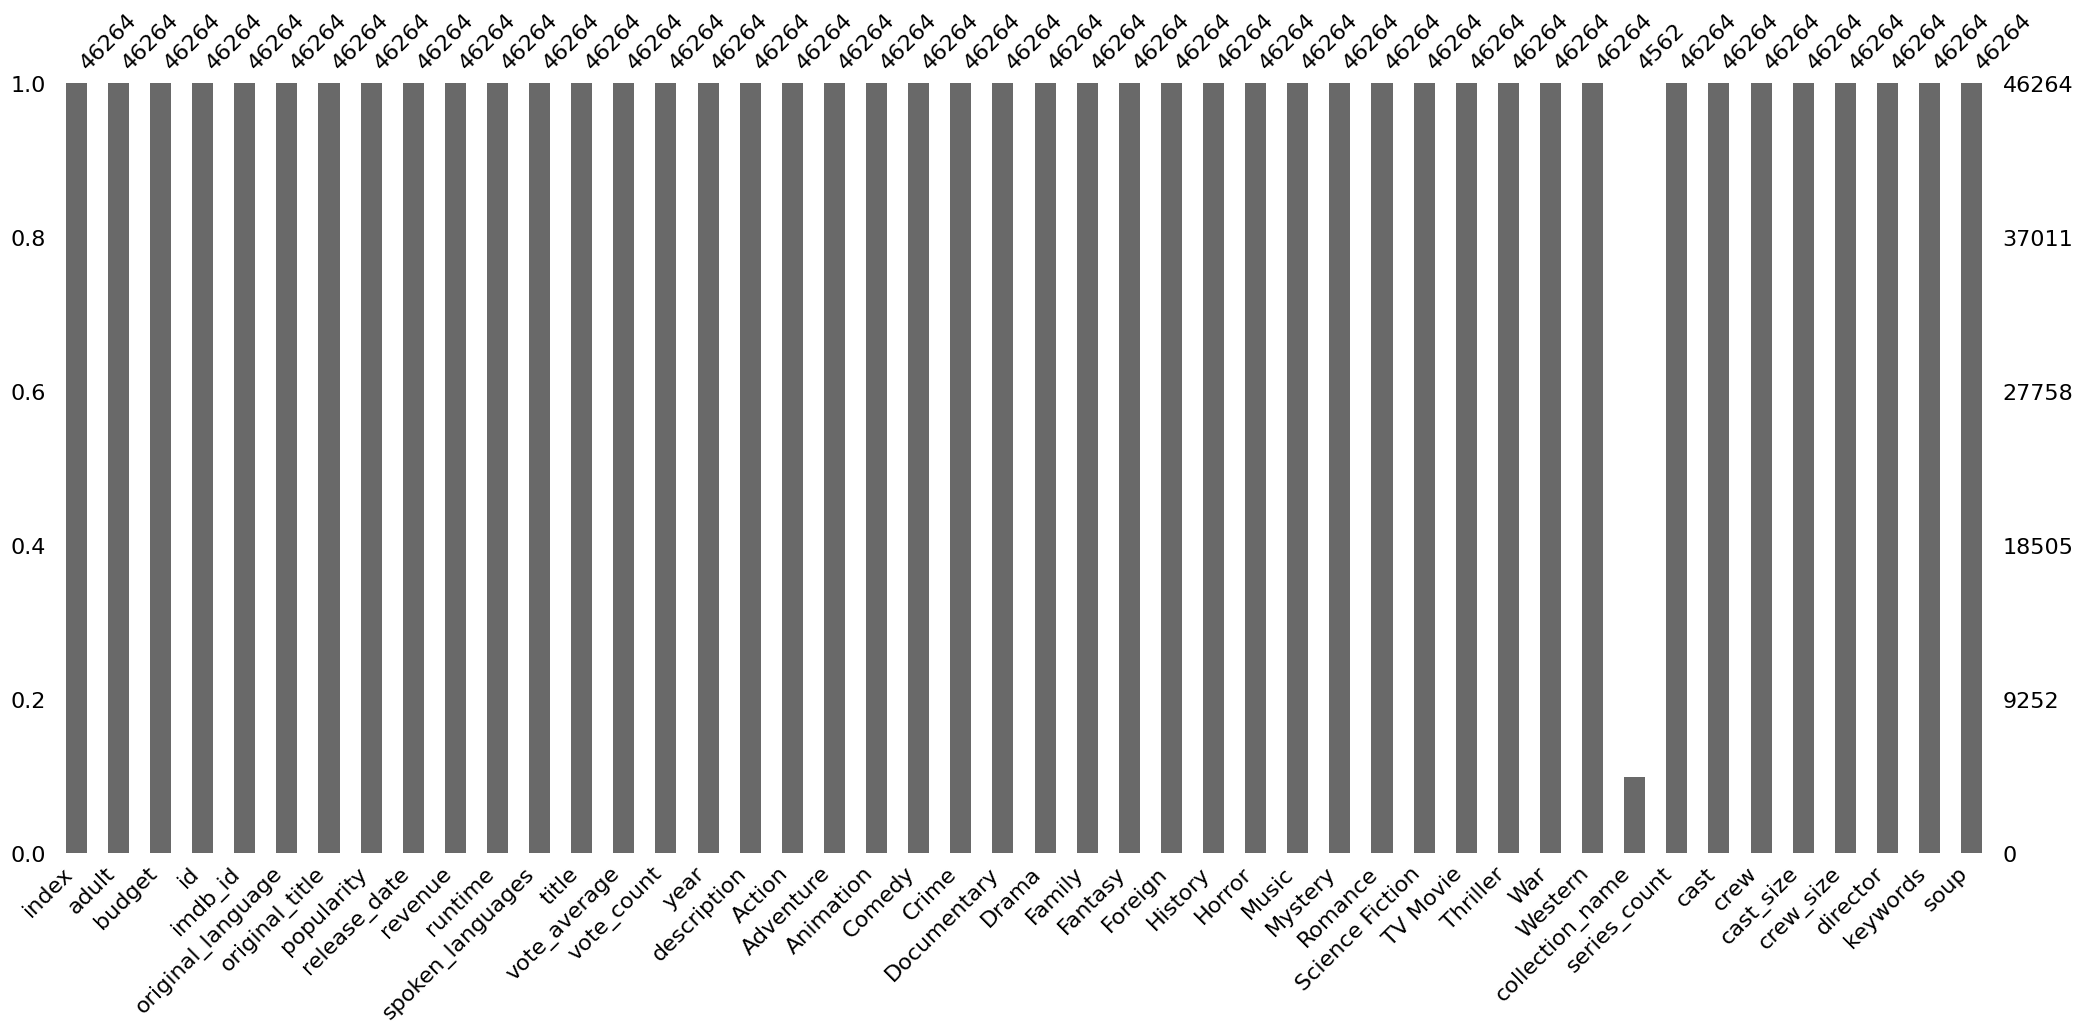

In [16]:
msno.bar(md)

### Content Based Recommender


In [15]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(md['soup'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
md = md.reset_index()
titles = md['title']
indices = pd.Series(md.index, index=md['title'])

In [80]:
def improved_recommendations(title):

    # Perhaps take adult or not into account (ie if kids movie, don't suggest other adult movie, maybe just add extra weight in dataset as this is probably already taken into account)
    try:
        idx = indices[title]

    except KeyError:
        print ("Movie title not found. Please enter another film")
        return

    if isinstance(idx, pd.Series):
        idx = idx.iloc[0] # Make selection user defined when frontend implemented
    
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = md.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [81]:
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()

m = vote_counts.quantile(0.95)

def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [82]:
improved_recommendations('Barbie')

Movie title not found. Please enter another film


In [90]:
reader = Reader()

In [91]:
ratings = pd.read_csv('data/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [92]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
kf = KFold(n_splits=5)
kf.split(data)

<generator object KFold.split at 0x2a36513f0>

In [93]:
svd = SVD()
evaluate(svd, kf, measures=['RMSE', 'MAE'])

NameError: name 'evaluate' is not defined